In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
#자연발생 클러스터링(민원 단계 컬럼 생성)
from jenkspy import JenksNaturalBreaks

parks_df = pd.read_csv("src/RF_parksdf_week_zone.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
outliers = parks_df[
    (parks_df["complaints_r300"] < lower_bound) |
    (parks_df["complaints_r300"] > upper_bound)
].copy()

parks_df = parks_df.drop(outliers.index).copy()

# 3) 필터된 데이터로 Jenks 적용
i = 3
breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print("경계값:", breaks.breaks_)

# 4) 레이블 부여
parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"],
    bins=breaks.breaks_,
    labels=range(i),
    include_lowest=True
)
parks_df["complaint_level"].value_counts()

경계값: [0, 913, 2107, 4099]


complaint_level
0    800
1    459
2    273
Name: count, dtype: int64

▶ 이상치 개수: 93

▶ 이상치 complaints_r300 기술통계:
count       93.000000
mean      6888.774194
std       4118.954353
min       4162.000000
25%       4644.000000
50%       5785.000000
75%       6924.000000
max      24051.000000
Name: complaints_r300, dtype: float64

▶ 이상치 샘플(상위 5건):
              address parking_type  operation_type  total_parking_spaces  \
168   강서구 화곡동 1030-33           NW               1                  27.0   
169   강서구 화곡동 1030-33           NW               1                  27.0   
166   강서구 화곡동 1030-33           NW               1                  27.0   
167   강서구 화곡동 1030-33           NW               1                  27.0   
1190    양천구 목동 532-18           NW               1                  30.0   

      base_parking_fee  base_parking_time  additional_unit_fee  \
168               50.0                5.0                 50.0   
169               50.0                5.0                 50.0   
166               50.0                5.0                 50.0   
167  

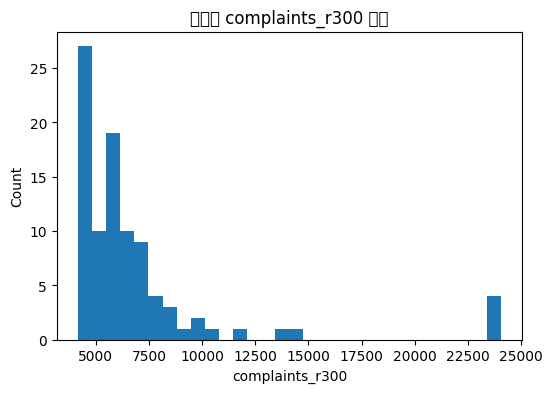

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# outliers: 이미 생성된 이상치 DataFrame

# 1) 이상치 개수·기술통계
print("▶ 이상치 개수:", len(outliers))
print("\n▶ 이상치 complaints_r300 기술통계:")
print(outliers["complaints_r300"].describe())

# 2) 상위/하위 몇 건 살펴보기
print("\n▶ 이상치 샘플(상위 5건):")
print(outliers.sort_values("complaints_r300", ascending=False).head(), "\n")
print("▶ 이상치 샘플(하위 5건):")
print(outliers.sort_values("complaints_r300", ascending=True).head())

# 3) 구역(zone)별 이상치 분포
if "zone" in outliers.columns:
    zone_counts = outliers["zone"].value_counts().sort_values(ascending=False)
    print("\n▶ 이상치 구역별 분포:")
    print(zone_counts)

# 4) 시작/종료 시간 분포
print("\n▶ 이상치 Weekday_start 분포:")
print(outliers["Weekday_start"].value_counts().sort_index())
print("\n▶ 이상치 Weekday_end 분포:")
print(outliers["Weekday_end"].value_counts().sort_index())

# 5) 낮/밤 영업시간 평균 비교
if {"day_open_hours","night_open_hours"}.issubset(outliers.columns):
    print("\n▶ 이상치 낮·밤 평균 영업시간:")
    print("  낮 평균:",  outliers["day_open_hours"].mean())
    print("  밤 평균:",  outliers["night_open_hours"].mean())

# 6) 시각화 예시: complaints_r300 히스토그램
plt.figure(figsize=(6,4))
plt.hist(outliers["complaints_r300"], bins=30)
plt.title("이상치 complaints_r300 분포")
plt.xlabel("complaints_r300")
plt.ylabel("Count")
plt.show()


In [3]:
print(parks_df.columns)

Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_start', 'Weekday_end',
       'Weekday_operatingHours', 'lon', 'lat', 'is_open_at_0', 'is_open_at_1',
       'is_open_at_2', 'is_open_at_3', 'is_open_at_4', 'is_open_at_5',
       'is_open_at_6', 'is_open_at_7', 'is_open_at_8', 'is_open_at_9',
       'is_open_at_10', 'is_open_at_11', 'is_open_at_12', 'is_open_at_13',
       'is_open_at_14', 'is_open_at_15', 'is_open_at_16', 'is_open_at_17',
       'is_open_at_18', 'is_open_at_19', 'is_open_at_20', 'is_open_at_21',
       'is_open_at_22', 'is_open_at_23', 'zoning_encoded', 'complaint_level'],
      dtype='object')


In [4]:
open_cols = [col for col in parks_df.columns if col.startswith('is_open_at_')]
parks_df = parks_df.drop(columns = open_cols)

In [5]:
parks_df['start_sin'] = np.sin(2*np.pi*parks_df['Weekday_start']/24)
parks_df['start_cos'] = np.cos(2*np.pi*parks_df['Weekday_start']/24)
parks_df['end_sin']   = np.sin(2*np.pi*parks_df['Weekday_end']/24)
parks_df['end_cos']   = np.cos(2*np.pi*parks_df['Weekday_end']/24)

In [7]:
'''# KMeans 기반 클러스터링

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

parks_df = pd.read_csv("src/RF_parksdf_week.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")
parks_df.columns

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
parks_df = parks_df[
    (parks_df["complaints_r300"] >= lower_bound) &
    (parks_df["complaints_r300"] <= upper_bound)
].copy()

k = 3

X = parks_df["complaints_r300"].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_.flatten()
sorted_idx = np.argsort(centers)
label_map = {old: new for new, old in enumerate(sorted_idx)}
sorted_labels = np.vectorize(label_map.get)(clusters)

parks_df["complaint_level"] = sorted_labels

parks_df["complaint_level"].value_counts().sort_index()
'''

'# KMeans 기반 클러스터링\n\nfrom sklearn.cluster import KMeans\nimport numpy as np\nimport pandas as pd\n\nparks_df = pd.read_csv("src/RF_parksdf_week.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")\nparks_df.columns\n\n# 1) IQR 계산\nQ1 = parks_df["complaints_r300"].quantile(0.25)\nQ3 = parks_df["complaints_r300"].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# 2) 이상치 제거\nparks_df = parks_df[\n    (parks_df["complaints_r300"] >= lower_bound) &\n    (parks_df["complaints_r300"] <= upper_bound)\n].copy()\n\nk = 3\n\nX = parks_df["complaints_r300"].values.reshape(-1, 1)\n\nkmeans = KMeans(n_clusters=k, random_state=0)\nclusters = kmeans.fit_predict(X)\n\ncenters = kmeans.cluster_centers_.flatten()\nsorted_idx = np.argsort(centers)\nlabel_map = {old: new for new, old in enumerate(sorted_idx)}\nsorted_labels = np.vectorize(label_map.get)(clusters)\n\nparks_df["complaint_level"] = sorted_labe

In [8]:
#범주형 변수의 label을 [0,1]로 변환
from sklearn.preprocessing import LabelEncoder

le_dict = {}

for col in ["parking_type", "operation_type", "Weekday_paid", "Saturday_paid", "Holiday_paid"]:
    if col in parks_df.columns:  # ✅ 존재하는 경우에만 처리
        le = LabelEncoder()
        parks_df[col] = le.fit_transform(parks_df[col])
        le_dict[col] = le

# 예시: parking_type의 범주와 정수 매핑 확인
for col in le_dict:
    print(f"{col}: {list(le_dict[col].classes_)}")

# [0, 1, 2, ...] 순서로 classes_에 저장됨
#['NS', 'NW'] -> [0,1]
#[1, 3] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]

parking_type: ['NS', 'NW']
operation_type: [1, 3]
Weekday_paid: ['N', 'Y']


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# 0) 데이터 준비axis=
X = parks_df.drop(["complaints_r300", "complaint_level", "address", "lat", "lon",
                   "base_parking_fee", "base_parking_time", "additional_unit_fee", "additional_unit_time",
                   "zoning_encoded", "Weekday_start", "Weekday_end"], axis=1)
y = parks_df["complaint_level"]

# 1) 80%를 train+val, 20%를 test로 분리 (stratify 유지)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) train_val(80%) 중 12.5%를 val로 → 전체 비율 10%, train은 70%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,    # 0.8 * 0.125 = 0.1
    stratify=y_train_val,
    random_state=42
)

# 3) 훈련셋에서만 RandomForest로 피처 중요도 계산
rf_fs = RandomForestClassifier(random_state=0)
rf_fs.fit(X_train, y_train)

importances = pd.Series(rf_fs.feature_importances_, index=X_train.columns)
top10 = importances.nlargest(10).index.tolist()
print("선택된 상위 10개 피처:", top10)

if 'start_sin' in top10 and 'start_cos' not in top10:
    top10.append('start_cos')
if 'start_cos' in top10 and 'start_sin' not in top10:
    top10.append('start_sin')
# 이렇게 하면 둘이 반드시 함께 들어감


# 4) 선택된 피처로 데이터 재정의
X_train_sel = X_train[top10]
X_val_sel   = X_val[top10]
X_test_sel  = X_test[top10]

# 5) 최종 모델 학습 & 평가
rf = RandomForestClassifier(
    random_state=0,
    class_weight="balanced"   # 클래스 불균형 보정
)
rf.fit(X_train_sel, y_train)

val_pred  = rf.predict(X_val_sel)
test_pred = rf.predict(X_test_sel)

print("Validation 정확도: {:.4f}".format(accuracy_score(y_val, val_pred)))
print("Test 정확도      : {:.4f}".format(accuracy_score(y_test, test_pred)))


선택된 상위 10개 피처: ['total_parking_spaces', 'bus_r300', 'cctv_r300', 'fee1H', 'Weekday_operatingHours', 'end_sin', 'end_cos', 'start_sin', 'start_cos', 'operation_type']
Validation 정확도: 0.6169
Test 정확도      : 0.7296


In [10]:
# Accuracy 분석

from sklearn.metrics import classification_report, accuracy_score

print("Complaint Level (Kmeans) Classification Accuracy:", round(accuracy_score(y_test, test_pred), 3))
print(classification_report(y_test, test_pred, target_names=['Low', 'Mid', 'High']))

Complaint Level (Kmeans) Classification Accuracy: 0.73
              precision    recall  f1-score   support

         Low       0.85      0.88      0.86       160
         Mid       0.60      0.55      0.58        92
        High       0.58      0.60      0.59        55

    accuracy                           0.73       307
   macro avg       0.68      0.68      0.68       307
weighted avg       0.73      0.73      0.73       307



In [11]:
importances = rf.feature_importances_
feature_names = top10  # DataFrame에서 feature 이름 추출

# 중요도 표 만들기
importance_table = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_table


,feature,importance
0,total_parking_spaces,0.225239
1,bus_r300,0.196104
3,fee1H,0.175595
2,cctv_r300,0.155748
6,end_cos,0.062120
5,end_sin,0.053904
4,Weekday_operatingHours,0.052679
9,operation_type,0.026863
7,start_sin,0.026162
8,start_cos,0.025584


In [12]:
# 클래스별 feature 중요도

import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ── 1) TreeExplainer 생성 ───────────────────────────────────────
explainer = shap.TreeExplainer(rf)

# ── 2) SHAP 값 계산 (클래스별 리스트 반환) ───────────────────────
#    shap_vals[i] 는 클래스 i 에 대한 (n_samples, n_features) shape
shap_vals = explainer.shap_values(X_train_sel)

# ── 3) 클래스별 평균 절댓값 SHAP 계산 ────────────────────────────
#    딕셔너리 컴프리헨션으로 DataFrame 생성
mean_abs_shap = pd.DataFrame({
    f'class_{cls}': np.abs(shap_vals[cls]).mean(axis=1)
    for cls in range(len(shap_vals))
}, index=top10)

# ── 4) 보기 좋게 정렬하거나 출력 ─────────────────────────────────
#    예: 클래스 0,1,2 순서대로 높은 순으로 정렬해서 보기
for cls in mean_abs_shap.columns:
    print(f"\n▶ 클래스 {cls[-1]} 기여도 상위 5개 피처")
    print(mean_abs_shap[cls].sort_values(ascending=False).head())



▶ 클래스 0 기여도 상위 5개 피처
end_cos                   0.099582
fee1H                     0.095519
end_sin                   0.076337
Weekday_operatingHours    0.061782
cctv_r300                 0.034981
Name: class_0, dtype: float64

▶ 클래스 1 기여도 상위 5개 피처
cctv_r300                 0.085584
fee1H                     0.064939
end_cos                   0.035387
bus_r300                  0.029805
Weekday_operatingHours    0.022860
Name: class_1, dtype: float64

▶ 클래스 2 기여도 상위 5개 피처
end_cos                   0.087365
operation_type            0.079873
end_sin                   0.062755
Weekday_operatingHours    0.059192
bus_r300                  0.049385
Name: class_2, dtype: float64

▶ 클래스 3 기여도 상위 5개 피처
bus_r300                  0.076570
cctv_r300                 0.075910
fee1H                     0.058186
end_cos                   0.046980
Weekday_operatingHours    0.041381
Name: class_3, dtype: float64

▶ 클래스 4 기여도 상위 5개 피처
cctv_r300                 0.085931
bus_r300                  0.069947


In [ ]:
'''
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('gradient boosting 정확도: {:.4f}'.format(accuracy))
'''

In [ ]:
## 요기부터 미완

In [15]:
import pandas as pd
import numpy as np

# 1. CSV 파일 읽기
#    파일 경로를 실제 파일명으로 바꿔주세요.
parks_df = pd.read_csv("src/dongParks_Holiday_zone.csv", encoding="utf-8")

# 3. 시계열 변수를 원형 변수로 변환
parks_df['start_sin'] = np.sin(2 * np.pi * parks_df['Holiday_start'] / 24)
parks_df['start_cos'] = np.cos(2 * np.pi * parks_df['Holiday_start'] / 24)
parks_df['end_sin']   = np.sin(2 * np.pi * parks_df['Holiday_end']   / 24)
parks_df['end_cos']   = np.cos(2 * np.pi * parks_df['Holiday_end']   / 24)

# 4. (선택) 처리 결과를 새 CSV로 저장
parks_df.to_csv("src/dongParks_Holiday_hour.csv", index=False, encoding="utf-8")


In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
pd.set_option('display.max_rows', None)

# 여기 요일타입에 따라 바꿔야 됩니다!!
dong_parks_df = pd.read_csv("src/dongParks_Weekday.csv")

dong_parks_df

# dong_parks_df의 feature 컬럼만 추출 (dong 이름 등 식별자 제외)
# 모델이 학습할 때 사용한 feature 리스트
model_features = list(rf.feature_names_in_)

# dong_parks_df에서 해당 컬럼만 추출
X_dong = dong_parks_df[model_features]
# 동별 민원 수준 예측
dong_parks_df['predicted_complaints'] = rf.predict(X_dong)

# 그룹별 동 이름 추출
high_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 2]['dong']
mid_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 1]['dong']
low_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 0]['dong']

# 각 그룹을 DataFrame으로 변환 (인덱스 리셋)
high_df = pd.DataFrame({'High 민원': high_dong.reset_index(drop=True)})
mid_df = pd.DataFrame({'Mid 민원': mid_dong.reset_index(drop=True)})
low_df = pd.DataFrame({'Low 민원': low_dong.reset_index(drop=True)})

# 길이가 다른 경우도 맞춰서 하나의 표로 합치기
dong_table = pd.concat([high_df, mid_df, low_df], axis=1)

from IPython.display import display
display(dong_table.head())

KeyError: "['end_sin', 'end_cos', 'start_sin', 'start_cos'] not in index"

In [28]:
import pandas as pd

pd.Series(rf.feature_importances_, index=X_dong.columns).sort_values(ascending=False)

total_parking_spaces      0.238468
bus_r300                  0.200366
fee1H                     0.185563
cctv_r300                 0.162077
Weekday_end               0.092352
Weekday_operatingHours    0.072580
Weekday_start             0.048594
dtype: float64

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_dong),
    columns=X_dong.columns
)

'''
# 정규화 수행
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dong), columns=X_dong.columns)
'''

# 정규화된 데이터 기준으로 영향력 큰 feature 추정
importances = rf.feature_importances_
dong_parks_df['top_feature'] = X_scaled.apply(
    lambda row: row.index[np.argmax(np.abs(row.values * importances))],
    axis=1
)

# 결과 출력
solution_table = dong_parks_df[['dong', 'predicted_complaints', 'top_feature']]
display(solution_table.head())

# 민원 수준별 요약
summary = solution_table.groupby('predicted_complaints')['top_feature'].value_counts()
print(summary)


,dong,predicted_complaints,top_feature
0,가락본동,2,cctv_r300
1,가리봉동,1,total_parking_spaces
2,가산동,0,bus_r300
3,가양1동,0,total_parking_spaces
4,가양2동,0,bus_r300


predicted_complaints  top_feature         
0                     fee1H                   48
                      bus_r300                47
                      total_parking_spaces    46
                      cctv_r300               25
                      Weekday_end              1
1                     fee1H                   33
                      cctv_r300               17
                      bus_r300                16
                      total_parking_spaces    13
2                     cctv_r300               24
                      total_parking_spaces    20
                      fee1H                   16
                      bus_r300                15
Name: count, dtype: int64


In [20]:
print(parks_gdf.columns)

Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_start', 'Weekday_end',
       'Weekday_operatingHours', 'lon', 'lat', 'complaint_level', 'dong'],
      dtype='object')


In [17]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1) 행정동 경계 불러오기 (EPSG:5179)
dong_boundaries = (
    gpd.read_file("src/dong_boundary.shp")
       .rename(columns={"ADM_NM":"dong"})
)

# 3) 주소에서 ‘○○동’ 부분만 추출해 두기
parks_df['addr_dong'] = parks_df['address'].str.extract(r'^\S+\s+(\S+동)')[0]

# 4) GeoDataFrame 생성 (위경도 → EPSG:4326 지정)
geometry = [Point(xy) for xy in zip(parks_df['lon'], parks_df['lat'])]
parks_gdf = gpd.GeoDataFrame(
    parks_df,
    geometry=geometry,
    crs="EPSG:4326"
)

# 5) 경계 CRS로 투영
parks_gdf = parks_gdf.to_crs(dong_boundaries.crs)

# ─────── 이 부분을 추가 ───────
# 6) 공간 결합
parks_gdf = gpd.sjoin(
    parks_gdf,
    dong_boundaries[['dong','geometry']],
    how='left',
    predicate='within'
)

# 7) NaN인 경우만 매핑 테이블로 보정
mapping = {
    '잠실동': '잠실본동',
    # 필요시 다른 주소-행정동도 여기에 추가
}
parks_gdf['dong'] = parks_gdf['dong'].fillna(
    parks_gdf['addr_dong'].map(mapping)
)
# ─────────────────────────────

# 8) 결과 확인
parks_gdf = parks_gdf.drop(columns=['addr_dong', 'geometry', 'index_right'])
print(parks_gdf.columns)


Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_start', 'Weekday_end',
       'Weekday_operatingHours', 'lon', 'lat', 'complaint_level', 'dong'],
      dtype='object')


In [18]:
import numpy as np
import pandas as pd
import shap

# 1) TreeExplainer 생성
explainer = shap.TreeExplainer(rf)
feature_cols = list(rf.feature_names_in_)

# 2) park-level SHAP 값 계산 (n_samples, n_features, n_classes)
raw_shap_p = explainer.shap_values(parks_gdf[feature_cols])

# 3) 클래스 차원 절댓값 평균 → (n_samples, n_features)
shap_abs_p = np.abs(raw_shap_p).mean(axis=2)

# 4) DataFrame으로 변환 후 dong 매핑
df_shap_p        = pd.DataFrame(shap_abs_p, columns=feature_cols)
df_shap_p['dong'] = parks_gdf['dong'].values

# 5) 행정동별 평균 SHAP 기여도 집계
dong_shap_mean = df_shap_p.groupby('dong').mean()

# 6) 행정동별 Top3 피처 추출
top3 = dong_shap_mean.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
df_top3 = (
    pd.DataFrame(top3.tolist(), index=top3.index, columns=['Top1','Top2','Top3'])
      .reset_index()
      .rename(columns={'index':'dong'})
)

# 7) 결과 확인
print(df_top3.head())


   dong                  Top1           Top2                    Top3
0  가락본동           Weekday_end          fee1H           Weekday_start
1  가리봉동             cctv_r300    Weekday_end    total_parking_spaces
2   가산동           Weekday_end  Weekday_start  Weekday_operatingHours
3  가양1동                 fee1H      cctv_r300    total_parking_spaces
4  가양2동  total_parking_spaces       bus_r300           Weekday_start


In [31]:
# 1) 실제 complaints_level: parks_gdf 에 이미 있다면 바로 사용
#    없다면, 원본 complaints_df 등에서 행정동별로 집계해서 merge

# 예: 원본 parks_df 에 'complaints_level' 컬럼이 있다고 가정
actual = parks_gdf.groupby('dong')['complaint_level'] \
                   .agg(lambda x: x.mode()[0]) \
                   .reset_index()

# 2) 예측 complaints_level
predicted = pd.DataFrame({
    'dong': parks_gdf['dong'],
    'predicted_level': rf.predict(parks_gdf[feature_cols])
}).groupby('dong')['predicted_level'] \
  .agg(lambda x: x.mode()[0]) \
  .reset_index()

# 3) df_top3 에 결합
df_insight = (
    df_top3
      .merge(actual,    on='dong', how='left')
      .merge(predicted, on='dong', how='left')
)

df_insight.head()


,dong,Top1,Top2,Top3,complaint_level,predicted_level
0,가락본동,Weekday_end,fee1H,Weekday_start,2,2
1,가리봉동,cctv_r300,Weekday_end,total_parking_spaces,1,1
2,가산동,Weekday_end,Weekday_start,Weekday_operatingHours,0,0
3,가양1동,fee1H,cctv_r300,total_parking_spaces,0,0
4,가양2동,total_parking_spaces,bus_r300,Weekday_start,0,0
